In [11]:
def do_setup():
    # How to download competition data to temp folder(data) 
    # unzip it there, then symlink it like its a subdir
    # NOTE: make sure kaggle.json is in /root/.kaggle/

    #remove original symlink from this directory
    !rm ./data
    
    #remove old setup files
    !rm setup.sh

    #create temp holder
    !mkdir /root/data

    #symlink it
    !ln -s /root/data ./data

    #download competition data to temp data folder
    !cd ./data;kaggle competitions download -c paddy-disease-classification

    #unzip it, -q is silent
    !cd ./data;unzip -q paddy-disease-classification.zip

    #setup dotfiles
    !wget "https://raw.githubusercontent.com/CNUClasses/dotfiles/master/setup.sh";chmod 766 setup.sh;source ./setup.sh  
    
import os
if(not os.path.exists('./data/train_images')):
   !chmod 600 /root/.kaggle/kaggle.json
   do_setup()  

In [12]:
try: from path import Path
except ModuleNotFoundError:
    !pip install path --quiet
try: import timm
except ModuleNotFoundError:
    !pip install timm --quiet

## Functions, constants, imports

In [76]:
import os
def get_fls(pth, ext=['.png','.jpg']):
    '''
    pth: recursively gather all image files in pth
    return: list of files (with absolute paths)
    '''
    pth=os.path.abspath(pth)       #absolute path
    ext=[ext.lower() for ext in ext]  #make sure lowercase
    res=[]
    for root,dirs,fles in os.walk(pth):
        for fle in fles:
            if os.path.splitext(fle)[1].lower() in ext:
                res.append(os.path.join(root,fle))
    return res

model_name='resnet26d'

In [21]:
import torch

## Work

### Read the dataframe

In [14]:
import pandas as pd
df =pd.read_csv('./data/train.csv')
# df

### Dataset

In [16]:
# #get a list of files
# trn_files=get_fls('./data/train_images')  
# tst_files=get_fls('./data/test_images') 
# print(f'Len train={len(trn_files)}, length test={len(tst_files)}')

Len train=10407, length test=3469


In [137]:
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms

class MultiTaskDatasetEval(Dataset):
    def __init__(self,img_dir,*,transforms=None, target_transform=None):
        self.files=get_fls(img_dir)
        self.transforms = transforms
        self.target_transform = target_transform  
     
    def __len__(self): return len(self.files)
        
    def __getitem__(self,idx):
        #dealing with the image
        image=read_image(str(self.files[idx]))       
        if self.transforms:
            image = self.transforms(image)      
        return image
    
# create a dict to map label strings to tensors
i_to_label=dict(enumerate(df.label.unique()))
label_to_i={v:i for i,v in i_to_label.items()}
#create another to map variety strings to tensors
i_to_variety=dict(enumerate(df.variety.unique()))
variety_to_i={v:i for i,v in i_to_variety.items()}
class MultiTaskDatasetTrain(Dataset): 
    def __init__(self,img_dir,*,df=None,transforms=None, target_transform=None):
        '''
        df: contains info to build train dataset
        img_dir: where images are ex "./data/train_images"
        transforms: list of transforms to apply      
        '''
        # super().init(img_dir,transforms=transforms,target_transforms=target_transforms)
        super().__init__()
        self.image_ids=df.loc[:,'image_id'].tolist()
        self.labels=df.loc[:,'label'].tolist()
        self.varietys=df.loc[:,'variety'].tolist()
        self.files=[]
        for image_id,label in zip(self.image_ids, self.labels):
            self.files.append(os.path.join(img_dir,label,image_id))
        assert len(self.files)==len(self.labels) and len(self.files)==len(self.varietys), f"files,labels and variety must be same length"

        #now convert the labels and varieties to numbers
        self.labels=list(map(label_to_i.get,self.labels))
        self.varietys=list(map(variety_to_i.get,self.varietys))
 
        self.transforms = transforms
        self.target_transform = target_transform       
        # self.size = len(self.files)

    def __len__(self): return len(self.files)

    def __getitem__(self,idx):
        #dealing with the image
        image=read_image(str(self.files[idx]))
        
        lbl=self.labels[idx]
        variety=self.varietys[idx]
        
        if self.transforms:
            image = self.transforms(image)
        # img = PIL.Image.open(self.paths[idx]).convert('RGB')
        # img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        # img = img.apply_tfms(self.transform, size = self.size)
        # img = self.norm(img.data)
        
        return image,lbl,variety
    
    def display(self,idx):
        image,lbl,variety=self[idx]
        print(f'{self.i_to_label[lbl]}')
        print(f'{self.i_to_variety[variety]}')
        # from fastai.vision.all import *
        # img=PILImage.create(files[0])
        # print(img.size)
        # img.to_thumb(128)



In [138]:
import torchvision.transforms as transforms
# from https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055        
def create_datasets(df,image_size, data_mean, data_std, train_path, val_path):

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ConvertImageDtype(torch.float),
        # transforms.ToTensor(), #not needed if already a tensor
        transforms.Normalize(mean=data_mean,std=data_std)
    ])
    val_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=data_mean,std=data_std)
    ])

    train_dataset = MultiTaskDatasetTrain(train_path,df=df,transforms=train_transforms)
    eval_dataset = MultiTaskDatasetEval(val_path,transforms=val_transforms)
    return train_dataset, eval_dataset

#get a list of transforms that the model needs
cfg=timm.data.resolve_data_config({}, model=model_name, verbose=True)

#get just the height and width
sze=cfg['input_size'][-2:]
train_path='./data/train_images'
val_path='./data/test_images'

trn_dataset, val_dataset=create_datasets(df,sze, cfg['mean'], cfg['std'], train_path, val_path)

In [139]:
print(f'Number train images={len(trn_dataset)}, number validation={len(val_dataset)}')

Number train images=10407, number validation=3469


### DataLoader

In [148]:
from torch.utils.data import DataLoader
trn_dl=DataLoader(trn_dataset, batch_size=4, shuffle=True, num_workers=2)
val_dl=DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2)

#### Check on DataLoader

Feature batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4])
Varieties batch shape: torch.Size([4])


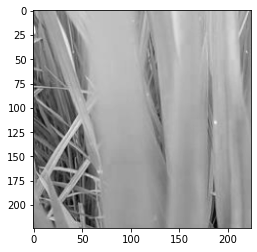

Label: normal
Variety: ADT45


In [149]:
import matplotlib.pyplot as plt
imgs,lbls,varieties = next(iter(trn_dl))
print(f"Feature batch shape: {imgs.size()}")
print(f"Labels batch shape: {lbls.size()}")
print(f"Varieties batch shape: {varieties.size()}")
img = imgs[0].squeeze()
label = lbls[0].item()
variety=varieties[0].item()
plt.imshow(img[0,:], cmap="gray")
plt.show()
print(f"Label: {i_to_label[label]}")
print(f"Variety: {i_to_variety[variety]}")

In [150]:
img=imgs[0].squeeze()
img[0,:].shape

torch.Size([224, 224])

### Define Multi Head Model (2 output params)

In [96]:
import torch.nn as nn
class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self,tmodel):
        '''
        tmodel: pretrained model
        ex:
        model_name='resnet26d'
        tmodel=timm.create_model(model_name, pretrained=True)
        m1=DiseaseAndTypeClassifier(tmodel)
        
        '''
        super().__init__()
        self.m = tmodel
        self.m.fc=nn.Sequential(
            nn.Linear(in_features=self.m.get_classifier().in_features,out_features=512, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4))
        # self.m.fc=nn.Linear(in_features=self.m.get_classifier().in_features,out_features=512, bias=False)
        self.l1=nn.Linear(in_features=512, out_features=10, bias=False)  #rice type
        self.l2=nn.Linear(in_features=512, out_features=10, bias=False)  #disease
        
    def forward(self,x):       
        x=self.m(x)
        label=self.l1(x)  #disease type
        variety=self.l2(x)  #variety
        return label,variety
    
    # def eval(self):
    #     super().eval()
    #     self.m.eval()
      

### Load Model

In [145]:
# tmodel=timm.create_model(model_name, pretrained=True)
tmodel=timm.create_model(model_name, pretrained=True, num_classes=13,global_pool='catavgmax')
m1=DiseaseAndTypeClassifier(tmodel)

# m2=timm.create_model(model_name, pretrained=True)

In [146]:
# m1.eval()
print(f'{m1.training}, {m1.m.training}, {m1.m.fc.training}')

True, True, True


In [151]:
m1.eval()
# m1(trn_dataset[0][0].unsqueeze(0))
m1(next(iter(trn_dl))[0])
# m1(val_dataset[0].unsqueeze(0))

# m1(torch.randn(1,3,224,224))

(tensor([[-0.2423,  1.0646,  1.5176,  1.2721, -0.7558,  0.7982, -1.0968,  0.6384,
          -0.0590, -0.6459],
         [-0.2881,  0.8208,  1.0551,  0.6277, -1.8699,  0.8511, -1.6767,  0.4299,
           0.9041, -1.0390],
         [-1.3031, -0.0481,  1.3752,  1.1199, -1.1819,  0.6820, -0.9120,  0.4471,
           0.3198, -0.9818],
         [-0.0966,  1.6562,  1.5197,  0.7939, -2.4215,  0.3157, -1.5987,  0.4960,
           1.3508, -1.1162]], grad_fn=<MmBackward0>),
 tensor([[-0.0140, -0.6201, -0.3709, -0.0627, -0.7518, -1.0921, -0.7114,  0.7783,
          -0.4669, -0.8032],
         [-0.5208, -0.4096, -0.5569,  0.4472, -0.6988, -1.4284, -1.5412,  0.0432,
          -0.6468,  0.4032],
         [ 0.8381, -0.0696, -0.5332,  0.2008, -0.8423, -0.4743, -0.9425,  0.5185,
          -0.8197, -0.8988],
         [-0.2367,  0.7766, -1.2370, -0.0240, -1.0840, -0.9530, -1.0735,  0.3381,
          -0.5302,  0.6186]], grad_fn=<MmBackward0>))

In [66]:
# import torch
# # m = timm.create_model('densenet121',pretrained=True)   #does not let head be replaced
# m = timm.create_model('resnet26d',pretrained=True,num_classes=20,global_pool='catavgmax')

# # m.reset_classifier(0)
# m.fc=nn.Sequential(
#             nn.BatchNorm1d(m.get_classifier().in_features),
#             nn.Linear(in_features=m.get_classifier().in_features,out_features=512, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.4),
#             nn.Linear(in_features=512,out_features=13,bias=False))
# m.eval()
# m(torch.randn(1,3,224,224))

# m.fc

# import timm
# m = timm.create_model('resnet26d',pretrained=True,num_classes=20,global_pool='catavgmax')
# print(m.default_cfg)
# num_in_features=m.get_classifier().in_features
# print(num_in_features)
# m.fc=nn.Sequential(
#     nn.BatchNorm1d(num_in_features),
#     nn.Linear(in_features=num_in_features,out_features=512, bias=False),
#     nn.ReLU(),
#     nn.BatchNorm1d(512),
#     nn.Dropout(0.4),
#     nn.Linear(in_features=512,out_features=20,bias=False))

# m.eval()
# m(torch.randn(1,3,224,224)).shape

In [91]:
train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        auto_augment="rand-m7-mstd0.5-inc1",
    )

NameError: name 'image_size' is not defined

In [254]:
trn_data.display(0)

bacterial_leaf_blight
ADT45


In [245]:

from torch.utils.data import DataLoader
train_dataloader = DataLoader(trn_data, batch_size=64, shuffle=True)

In [148]:
# df.columns

# # img,lbl,variety,age=df.iloc[0]
# # df.loc[:,'image_id'].tolist()

# os.path.join("./data/train_images",b,a)

# f=trn_files[0]
# f.split('/')[-2]

# df.loc[:,'variety'].map(mds.variety_to_i)

# for i in range(5):
#     print(mds[i])lbl

# len(mds)
mds[0]

## Experiment

In [ ]:
        
#         for imgs,lbls,variety,age=self.df.iloc[idx]
        
#         self.files = get_fls(img_dir) 
#         self.labels = [ label_to_i[f.split('/')[-2]] for f in self.files]  #gets parent
#         self.variety=[variety_to_i[df.loc[df['image_id']==f.split('/')[-1]].iloc[0].variety] for f in self.files]
#         # self.labels = [ label_to_i[f.parent.name] for f in self.files]        
        # self.variety=[variety_to_i[df.loc[df['image_id']==f.name].iloc[0].variety] for f in self.files]


In [99]:
trn_files[0].split('/')[-1]

'100081.jpg'

In [97]:
os.path.dirname(trn_files[0]).split('/')[-1]


'bacterial_leaf_streak'

In [5]:
#exploring pathlib
# import os
# p1=os.getcwd()
# p1

# import pathlib
# p = Path('.')
# [x for x in p.dirs()]
# # p.abspath()
# # p.getcwd()
# # p.

# # [x for x in p.iterdir() if x.is_dir()]
# p/'dta'

In [14]:
%time
y=2
x=1+1

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


In [57]:
%%time
files=get_fls('./data/test_images')   

CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 11.5 ms


In [55]:
from fastai.vision.all import *
# set_seed(42)
import pathlib
path =Path('./data/')

fastai.vision.all.get_image_files??
pth = Path('./data')

Object `fastai.vision.all.get_image_files` not found.


In [58]:
%%time
files1=get_image_files(path/'test_images')

CPU times: user 19.3 ms, sys: 0 ns, total: 19.3 ms
Wall time: 18 ms


(480, 640)


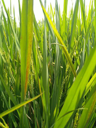

In [60]:
from fastai.vision.all import *
img=PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [63]:
%%time
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
sizes=parallel(f,files1,n_workers=8)
pd.Series(sizes).value_counts()

CPU times: user 1.41 s, sys: 443 ms, total: 1.85 s
Wall time: 11.8 s


(480, 640)    3467
(640, 480)       2
dtype: int64

In [64]:
%%time
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
sizes=parallel(f,files,n_workers=8)
pd.Series(sizes).value_counts()

CPU times: user 1.49 s, sys: 351 ms, total: 1.84 s
Wall time: 11.7 s


(480, 640)    3467
(640, 480)       2
dtype: int64

In [11]:
trnpath=path/'train_images'

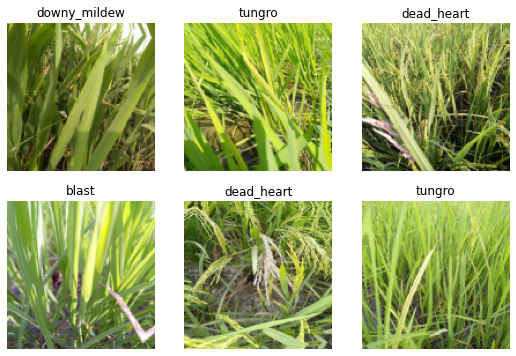

In [12]:
dls=ImageDataLoaders.from_folder(trnpath, valid_pct=0.2, seed=42,item_tfms=Resize(480, method='squish'),batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=6)

In [13]:
learn=vision_learner(dls,'resnet26d', metrics=error_rate,path='.')
# learn.model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


In [14]:
# learn.lr_find(suggest_funcs=(valley,slide))

In [15]:
# learn.fine_tune(3,0.01)

### Try multihead

In [16]:
# #get the model thats part of learner
# m=learn.model
# # m

# #gets the head of the model
# h=m[1]
# h

# #subtract the last layer
# ll=h[-1]
# ll

# llp=list(ll.parameters())[0]

# #get rid of last linear layer in model
# del(h[-1])
# # m

# # learn.model

## Load TIMM model

In [44]:
# timm.list_models(pretrained=True)



2048

In [46]:
import timm
m = timm.create_model('resnet26d')

num_in_features=m.get_classifier().in_features
m.fc=nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features=num_in_features,out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features=512,out_features=10,bias=False))
# m

In [47]:
m.eval()
m(torch.randn(1,3,224,224)).shape

torch.Size([1, 10])

In [7]:
allmods=timm.list_models(pretrained=True)
len(allmods)

770

## Custom dataset

In [20]:
from torch.utils.data import Dataset

In [58]:
# df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [8]:
f=files[0]

NameError: name 'files' is not defined

In [101]:
f=files[0]
df.loc[df['image_id']==f.name]

,image_id,label,variety,age
621,100081.jpg,bacterial_leaf_streak,Onthanel,50


In [102]:
files = get_image_files(path/'train_images')
labels = [f.parent.name for f in files]
variety=[df.loc[df['image_id']==fle.name].iloc[0].variety for fle in files]
print(files[0])
print(labels[0])
print(variety[0])
print(files[0].name)

data/train_images/bacterial_leaf_streak/100081.jpg
bacterial_leaf_streak
Onthanel
100081.jpg


In [85]:
# k=3
# k=torch.tensor(4,dtype=torch.int8)
# k

tensor(4, dtype=torch.int8)

In [149]:
fls=get_image_files(path/'train_images') 
str(fls[0])

'data/train_images/bacterial_leaf_streak/100081.jpg'

In [151]:
mds=MultiTaskDataset(df,"./data/train_images",transform=to)

In [152]:
# len(mds)
mds[0]

(tensor([[[221, 217, 167,  ..., 139, 109, 140],
          [211, 220, 187,  ..., 134, 127, 164],
          [212, 210, 199,  ..., 129, 114, 154],
          ...,
          [ 64,  76,  77,  ...,  83,  82,  81],
          [ 39,  54,  61,  ...,  81,  77,  94],
          [ 44,  56,  59,  ...,  80,  74, 102]],
 
         [[255, 255, 206,  ..., 160, 134, 168],
          [252, 255, 226,  ..., 151, 147, 187],
          [251, 250, 239,  ..., 137, 124, 165],
          ...,
          [ 71,  83,  84,  ..., 107, 109, 109],
          [ 48,  64,  70,  ..., 105, 104, 122],
          [ 53,  65,  68,  ..., 104, 101, 130]],
 
         [[ 16,  23,   0,  ..., 103,  68,  94],
          [  8,  24,  11,  ...,  97,  84, 119],
          [ 10,  16,  21,  ...,  88,  71, 107],
          ...,
          [ 38,  49,  51,  ...,  55,  58,  58],
          [ 17,  30,  39,  ...,  53,  53,  71],
          [ 22,  34,  37,  ...,  52,  50,  79]]], dtype=torch.uint8),
 1,
 3)

In [ ]:
class PaddyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Multihead

In [7]:
#creae a dict that maps from image_id to variety
img_id=df.image_id
variety=df.variety

itov=dict(zip(img_id,variety))

def getvariety(p): return itov[p.name]
    

NameError: name 'df' is not defined

In [61]:
dls=ImageDataLoaders.from_folder(trnpath, valid_pct=0.2, seed=42,item_tfms=Resize(192,method='squish'),batch_tfms=aug_transforms(size=128, min_scale=0.75))

In [60]:
dblock=DataBlock(blocks=(ImageBlock, CategoryBlock, CategoryBlock),   #ImageBlock works if passed a path to image, CategoryBlock works if passed a string to categorify to an int
                 n_inp=1,   #imageblock
                 get_items=get_image_files,
                 get_y=[parent_label,getvariety],  #2 cat blocks ricetype and disease variety type
                 splitter=RandomSplitter(0.2, seed=42),
                 item_tfms=Resize(192,method='squish'),
                 batch_tfms=aug_transforms(size=128, min_scale=0.75))

In [19]:
train_pth=path/'train_images'
train_pth

Path('data/train_images')

In [20]:
ds=dblock.datasets(train_pth)

In [21]:
fn=get_image_files(train_pth)[0]
print(fn)

# PILImage.create(fn)
print(parent_label(fn))
print(getvariety(fn))

data/train_images/bacterial_leaf_streak/100081.jpg
bacterial_leaf_streak
Onthanel


In [22]:
img,y1,y2=ds.train[1]

In [23]:
y1

TensorCategory(5)

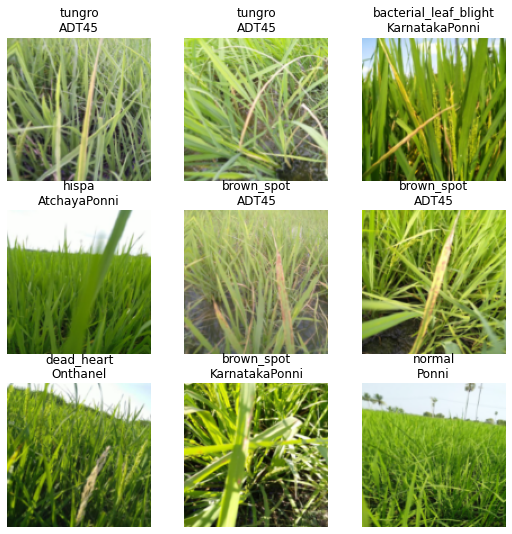

In [62]:
dls=dblock.dataloaders(train_pth)
dls.show_batch()

In [ ]:
#gets all the image files in a folder
# len(get_image_files('./data'))

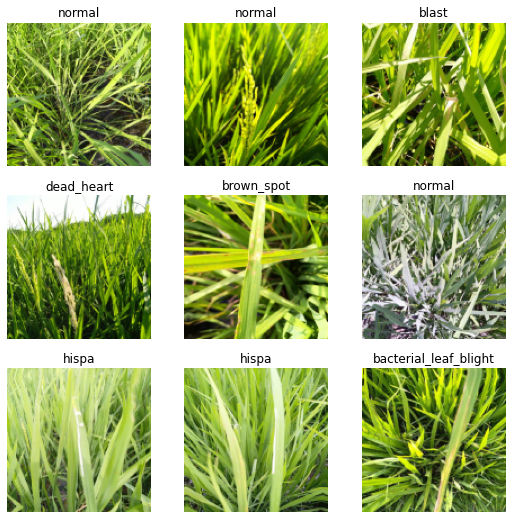

In [52]:
learn.dls.show_batch()

In [25]:
import torch.nn as nn
class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self,m):
        #lets strip the last layer out of the head
        del m[1][-1]
        super(DiseaseAndTypeClassifier,self).__init__()
        self.l1=nn.Linear(in_features=512, out_features=10, bias=False)  #rice type
        self.l2=nn.Linear(in_features=512, out_features=10, bias=False)  #disease
        self.m=m
        
    def forward(self,x):
        x=self.m(x)
        x1=self.l1(x)  #rice type
        x2=self.l2(x)  #disease
        return x1,x2
      

In [ ]:
# learn=vision_learner(dls,'resnet26d',  metrics=dtc_error)
dtc=DiseaseAndTypeClassifier(model)

In [26]:
# Learner??

In [27]:
learn.loss_func
c_loss=learn.loss_func

In [56]:
def dtc_loss(preds,y_label,y_variety):
    rice_preds, variety_preds=preds
    return c_loss(rice_preds,y_label)+c_loss(variety_preds,y_variety)

def dtc_error(preds,y_label,y_variety):
    rice_preds, variety_preds=preds
    return error_rate(rice_preds,y_label)+error_rate(variety_preds,y_variety)

In [63]:
learn.dls=dls
learn.model=dtc
learn.loss_func=dtc_loss
learn.metrics=[dtc_error]

In [54]:
preds=learn.get_preds(dl=learn.dls.valid)

SuggestedLRs(valley=0.004365158267319202)

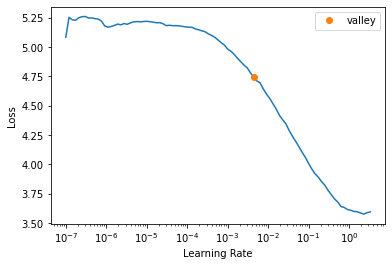

In [58]:
learn.lr_find()

In [64]:
learn.fine_tune(3,0.01)

epoch,train_loss,valid_loss,dtc_error,time
0,1.217758,1.125744,0.366170,00:23


epoch,train_loss,valid_loss,dtc_error,time
0,0.872258,0.682364,0.209995,00:28
1,0.643730,0.531604,0.154253,00:28
2,0.495419,0.485573,0.146084,00:28


In [ ]:
#size of validation set?
len(learn.dls.valid.get_idxs())

In [ ]:
rice_preds, disease_preds=preds

In [ ]:
#copy and deepcopy is causing problems below
# from copy import copy,deepcopy
# arch='resnet26d'
# dls=ImageDataLoaders.from_folder(trnpath, valid_pct=0.2, seed=42,item_tfms=Resize(480),batch_tfms=aug_transforms(size=224, min_scale=0.75))
# learn3=vision_learner(dls,arch,metrics=error_rate)
# learn2=deepcopy(learn3)

## Old notebook

In [ ]:
llp.shape

In [ ]:
path

In [ ]:
ss=pd.read_csv(path/'sample_submission.csv')

In [ ]:
ss

In [ ]:
tst_files=get_image_files(path/'test_images').sorted()

tst_dl=dls.test_dl(tst_files)

In [ ]:
probs, bb, idxs=learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

In [ ]:
dls.vocab

In [ ]:
d=dict(enumerate(dls.vocab))

In [ ]:
idxs_np=idxs.clone()

In [ ]:
idxs

In [ ]:
vals=pd.Series(data=idxs, name="idxs").map(d)
vals

In [ ]:
ss.label=vals

In [ ]:
ss

In [ ]:
ss.to_csv('subm.csv',index=False)

In [ ]:
!pwd

In [ ]:
from kaggle import api
comp = 'paddy-disease-classification'
api.competition_submit_cli('subm.csv', 'init', comp)